# Self Driving Car Engineer Nandodegree
## Project 3 - Behavioural Cloning
### Vilas Chitrakaran, Feb 2017

## Introduction
__TODO__

In [1]:
# Load the input data meta file
import os
import csv

samples = []
with open('./sample_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

Number of samples:  8036
Data format:  ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
Steering range: ( -0.942695 , 1.0 )


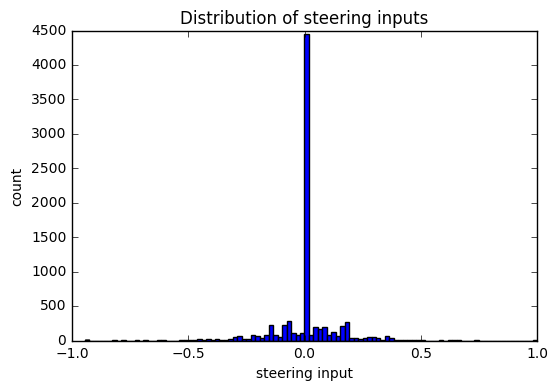

In [2]:
# Visualise steering distributions
# Note: Not sure what units they are in. If it's 'angle', it's most likely to be radians
# Note: NVidia paper uses inverse radius 1/r for steering input

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# note: first line of the CSV file is the header

print('Number of samples: ', len(samples)-1)
print('Data format: ', samples[0]) 
center_image_names = ['./sample_data/IMG/'+x[0].split('/')[-1] for x in samples[1:]]
steering = [np.float32(x[3]) for x in samples[1:]]
print('Steering range: (', min(steering), ',', max(steering), ')')

plt.hist(steering, bins=101)
plt.xlabel('steering input')
plt.ylabel('count')
plt.title('Distribution of steering inputs')
plt.show()

In [3]:
# Preprocess input data
# TODO
# - remove instances of steer == 0
# - increase data by flipping images and angles
# - increase data by using left images and damping left steers and enhancing right steers
# - increase data by using right images and damping right steers and enhancing left steers

In [4]:
# split data into training and validation sets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
shuffle(samples)
train_samples, validation_samples = train_test_split(samples[1:], test_size=0.2)
print('Number of training samples:', len(train_samples))
print('Number of validation samples:', len(validation_samples))

Number of training samples: 6428
Number of validation samples: 1608


In [5]:
# Generator function to avoid loading all images and data into memory
# TODO: requires modification to use augmented images

from scipy import ndimage

def generate_batch(samples, batch_size):
    num_samples = len(samples)
    images = np.zeros((batch_size, 160, 320, 3))
    angles = np.zeros(batch_size)
    
    while 1: 
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            for batch_sample in batch_samples:
                name = './sample_data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = ndimage.imread(name)
                #center_image = center_image[80:,:,:] # trim image to only see section with road
                
                #TODO: convert into YUV
 
                center_angle = np.float32(batch_sample[3])
                               
                images[i] = center_image
                angles[i] = center_angle

            yield images, angles

In [7]:
# Test the generator
for i in range(2):
    image, angle = (next(generate_batch(train_samples, 32)))
    #plt.figure()
    #plt.imshow(image[i])
    #print(angle[i])

In [10]:
# Define network
# We implement CNN architecture from the nvidia paper with a couple of modifications 
# Sequential architecture is organised as follows:

# - input image (YUV), 3@80x320
# - normalisation, 3@80x320
# - convolution (5x5, stride=2), 24@38x158
# - convolution (5x5, stride=2), 36@17x77
# - convolution (5x5, stride=2), 48@7x37
# - convolution (3x3, stride=2), 64@3x18
# - convolution (3x3, strive=1), 64@1x16
# - flatten (1024)
# - fully connected (100) 
# - fully connected (50)
# - fully connected (10)
# - fully connected (1)
# - Output

from keras.models import Sequential
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

ch, rows, cols = 3, 160, 320 # Trimmed YUV images

# generate the neural network
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(rows, cols, ch), output_shape=(rows, cols, ch)))
model.add(Convolution2D(24, 5, 5, activation=None, subsample=(2,2)))
model.add(Convolution2D(36, 5, 5, activation=None, subsample=(2,2)))
model.add(Convolution2D(48, 5, 5, activation=None, subsample=(2,2)))
model.add(Convolution2D(64, 3, 3, activation=None, subsample=(2,2)))
model.add(Convolution2D(64, 3, 3, activation=None, subsample=(1,1)))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

# print a summary of the NN
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 78, 158, 24)   1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 37, 77, 36)    21636       convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 17, 37, 48)    43248       convolution2d_7[0][0]            
___________________________________________________________________________________________

In [11]:
# compile and train the model using the generator function
EPOCHS = 1
BATCH_SIZE = 32

train_generator = generate_batch(train_samples, batch_size=BATCH_SIZE)
validation_generator = generate_batch(validation_samples, batch_size=BATCH_SIZE)

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                    nb_epoch=EPOCHS)

Epoch 1/3
6400/6428 [============================>.] - ETA: 0s - loss: 0.0829

/home/vchitrakaran/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6432/6428 [==============================] - 118s - loss: 0.0825 - val_loss: 3.2343e-04
Epoch 2/3
6432/6428 [==============================] - 117s - loss: 3.8060e-04 - val_loss: 3.9722e-04
Epoch 3/3
6432/6428 [==============================] - 119s - loss: 3.3748e-04 - val_loss: 3.0586e-04


In [12]:
# Save the model and weights
from keras.models import load_model
model.save("./model.h5")
print("Saved model to disk")

Saved model to disk
